Instructions:
The arrow -> indicates the shell commands you should type on your personal computer, and a-> for aleph

Setup

0. Install [miniconda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/linux.html) on aleph
1. Add the [conda forge](https://conda-forge.org) channel:
    a->conda config --add channels conda-forge
    a->conda config --set channel_priority strict
2. create a [conda environment](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html), for example:
    a->conda create -n research jupyterlab xarray dask scipy cartopy cmocean tqdm
    <p> The name "research" is arbitrary, pick whatever you want.
    The list starting with "jupyterlab" are the python packages you want. I likely forgot some, just install them with:</p>
    a->conda install -n research $package
3. Add the following line to your .bashrc on aleph: alias jrl='jupyter lab --no-browser --port=8889'
4. Add the following line to your .profile on your mac (or .bashrc, or whatever shell you use):
    alias jcon='ssh -N -L localhost:8888:localhost:8889'
5. Set up your .ssh/config file on your mac if you haven't already. Mine is like this:
        Host da3
                Hostname 203.247.189.225
                Port 4022
                User kstein
                
ALL THE ABOVE IS DONE ONCE. 

Then to run jupyterlab on aleph, use:

1. ->ssh -Y da3 (use your node)
2. cd to your project directory
3. a->conda activate research
    <p> you should now see (research) at the end of your prompt. </p>
4. a->jrl
<p> Jupyer lab will start up, and a token will be generated that you might need. crtl-c copy the token </p>
5. ->jcon da3
6. Open your favorite internet browser and go to: http://localhost:8888

# The mpirun command:
mpirun --np 6 dask-mpi --scheduler-file /proj/kstein/ESM2M/scheduler.json --no-nanny

Open a terminal and type in the above command, editing the path as desired. You should adjust the number of processes (6 in the above) depending on your server and how many users are on it.

Notebooks like this one are good for testing code. Once your codes is fully tested and your want to run it in batch mode, that is easy to do using [Dask-MPI's](http://mpi.dask.org/en/latest/) initialize() function.

In [1]:
from dask.distributed import Client
client = Client(scheduler_file='/proj/kstein/ESM2M/scheduler.json')

In [2]:
client

Client Scheduler: tcp://203.247.189.225:8786 Dashboard: http://203.247.189.225:8787/status,Cluster Workers: 5 Cores: 180 Memory: 4.05 TB


In [3]:
import numpy as np
import xarray as xr 
from tqdm import tqdm
import gsw
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cf
import dask
import time

In [4]:
def process_coords(ds, concat_dim='time', drop=True, extra_coord_vars=['time_bound']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = [v for v in ds.data_vars if concat_dim not in ds[v].dims]
    for ecv in extra_coord_vars:
        if ecv in ds:
            coord_vars += extra_coord_vars
    if drop:
        return ds.drop(coord_vars)
    else:
        return ds.set_coords(coord_vars)

In [5]:
def open_ESM2M_5D(files):
    ds = []
    ds = xr.open_mfdataset(files,
                           chunks={'time': 1},
                           concat_dim='time',
                           combine='nested',
                           preprocess=process_coords,
                           parallel='True',
                           decode_cf=False,
                           decode_times=False)
    ds = ds.assign_coords(xt_ocean=(((ds.xt_ocean + 180) % 360) - 180))
    ds = ds.roll(xt_ocean=180,roll_coords=True)
    ds['time'] = xr.cftime_range(start='1950-01-01', end='2100-12-31', freq='5D', calendar='noleap')
    return ds

In [6]:
def open_ESM2M_ensemble(scenario = 'RCP85',ensembles=[101,102],domain = 'OCN_5D',var = 'temp'):
    ens_dir = '/proj/krodgers/ESM2M/ENSEMBLE/'
    datadir = ens_dir + 'ENSEMBLE_' + scenario + '/ENS' + str(ensembles[0]) + '/' + domain + '/'
    ds = []
    ds_ens = []
    files = [datadir + var + '_1x1_ens' + str(ensembles[0]) + '_5d_' + str(year) +'.nc'  for year in range(1950,2101)]
    ds_ens = open_ESM2M_5D(files)
    ds_ens = ds_ens.expand_dims('member')
    ds_ens['member'] = [ensembles[0]]


    for member in tqdm(ensembles[1:]):
        datadir = ens_dir + 'ENSEMBLE_' + scenario + '/ENS' + str(member) + '/' + domain + '/'
        files = [datadir + var +  '_1x1_ens' + str(member) + '_5d_' + str(year) +'.nc'  for year in range(1950,2101)]
        ds = open_ESM2M_5D(files)
        ds = ds.expand_dims('member')
        ds['member'] = [member]
        ds_ens = xr.concat([ds_ens,ds],'member')
        
    return ds_ens

In [7]:
ens_start = 101
ens_end = 105
memberlist = range(ens_start,ens_end+1)

Unfortunately, opening all the netcdf files is a fairly slow processs. 

In [8]:
temp_ds_ens = open_ESM2M_ensemble(ensembles=memberlist)

100%|██████████| 4/4 [00:46<00:00, 11.51s/it]


In [9]:
salt_ds_ens = open_ESM2M_ensemble(ensembles=memberlist,var = 'salt')

100%|██████████| 4/4 [00:40<00:00, 10.19s/it]


In [10]:
rho_ds_ens = open_ESM2M_ensemble(ensembles=memberlist,var = 'pot_rho_0')

100%|██████████| 4/4 [00:48<00:00, 12.19s/it]


In [11]:
o2_ds_ens = open_ESM2M_ensemble(ensembles=memberlist,var = 'o2')

100%|██████████| 4/4 [00:51<00:00, 12.76s/it]


In [12]:
ds = xr.merge([temp_ds_ens,salt_ds_ens,rho_ds_ens,o2_ds_ens])

In [13]:
lons=[-85,25]
lats=[25,70]
depths=[0,400]
ds = ds.sel(xt_ocean = slice(lons[0],lons[1]))
ds = ds.sel(yt_ocean =slice(lats[0],lats[1]))
ds = ds.sel(st_ocean =slice(depths[0],depths[1]))

In [14]:
ds['temp'] = ds.temp.where(ds.temp>-1e19)

In [15]:
ds = ds.rename_vars({'pot_rho_0':'rho'})

In [16]:
ds

<xarray.Dataset>
Dimensions:   (member: 5, st_ocean: 29, time: 11023, xt_ocean: 110, yt_ocean: 45)
Coordinates:
  * yt_ocean  (yt_ocean) float64 25.5 26.5 27.5 28.5 ... 66.5 67.5 68.5 69.5
  * time      (time) object 1950-01-01 00:00:00 ... 2100-12-27 00:00:00
  * xt_ocean  (xt_ocean) float64 -84.5 -83.5 -82.5 -81.5 ... 21.5 22.5 23.5 24.5
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 35.0 ... 270.6 298.3 335.7 384.6
  * member    (member) int64 101 102 103 104 105
Data variables:
    temp      (member, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 29, 45, 110), meta=np.ndarray>
    salt      (member, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 29, 45, 110), meta=np.ndarray>
    rho       (member, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 29, 45, 110), meta=np.ndarray>
    o2        (member, time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 29, 45, 110), meta=np.ndarray>

In [17]:
ds.o2

<xarray.DataArray 'o2' (member: 5, time: 11023, st_ocean: 29, yt_ocean: 45, xt_ocean: 110)>
dask.array<getitem, shape=(5, 11023, 29, 45, 110), dtype=float32, chunksize=(1, 1, 29, 45, 110)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 25.5 26.5 27.5 28.5 ... 66.5 67.5 68.5 69.5
  * time      (time) object 1950-01-01 00:00:00 ... 2100-12-27 00:00:00
  * xt_ocean  (xt_ocean) float64 -84.5 -83.5 -82.5 -81.5 ... 21.5 22.5 23.5 24.5
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 35.0 ... 270.6 298.3 335.7 384.6
  * member    (member) int64 101 102 103 104 105
Attributes:
    long_name:      Oxygen
    units:          mol/kg
    missing_value:  -1e+20
    _FillValue:     -1e+20
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    interp_method:  conserve_order1

In [18]:
ds.temp

<xarray.DataArray 'temp' (member: 5, time: 11023, st_ocean: 29, yt_ocean: 45, xt_ocean: 110)>
dask.array<where, shape=(5, 11023, 29, 45, 110), dtype=float32, chunksize=(1, 1, 29, 45, 110)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 25.5 26.5 27.5 28.5 ... 66.5 67.5 68.5 69.5
  * time      (time) object 1950-01-01 00:00:00 ... 2100-12-27 00:00:00
  * xt_ocean  (xt_ocean) float64 -84.5 -83.5 -82.5 -81.5 ... 21.5 22.5 23.5 24.5
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 35.0 ... 270.6 298.3 335.7 384.6
  * member    (member) int64 101 102 103 104 105
Attributes:
    long_name:      Potential temperature
    units:          degrees K
    valid_range:    [-10. 500.]
    missing_value:  -1e+20
    _FillValue:     -1e+20
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_potential_temperature
    interp_method:  conserve_order1

In [19]:
gsw.O2sol_SP_pt?

Signature: gsw.O2sol_SP_pt(SP, pt)
Docstring:
Calculates the oxygen concentration expected at equilibrium with air at
an Absolute Pressure of 101325 Pa (sea pressure of 0 dbar) including
saturated water vapor.  This function uses the solubility coefficients
derived from the data of Benson and Krause (1984), as fitted by Garcia
and Gordon (1992, 1993).

Parameters
----------
SP : array-like
    Practical Salinity (PSS-78), unitless
pt : array-like
    Potential temperature referenced to a sea pressure, degrees C

Returns
-------
O2sol : array-like, umol/kg
    solubility of oxygen in micro-moles per kg
File:      ~/miniconda3/envs/research3/lib/python3.7/site-packages/gsw/_wrapped_ufuncs.py
Type:      function


In [20]:
o2sol = xr.apply_ufunc(gsw.O2sol_SP_pt,
                        ds.salt.chunk(),ds.temp.chunk() - 273.15,
                        dask='parallelized',
                        output_dtypes=[ds.temp.dtype])

In [21]:
O2PP = 0.21*(ds.o2*1e6)/o2sol

In [22]:
def metabolic_index(T,O2PP,A0 = 3.1e-14,E0 = 0.87,B=1,n=0):
    kB = 8.617333262145e-5
    B = 1000
    n = -.21
    den = np.exp(-E0/(kB*T))
    MI = A0 * (B**n) * (O2PP/den)
    
    return MI

In [23]:
met_index = xr.apply_ufunc(metabolic_index,
                           ds.temp.chunk(),O2PP.chunk(),
                           dask='parallelized',
                           output_dtypes=[ds.temp.dtype])

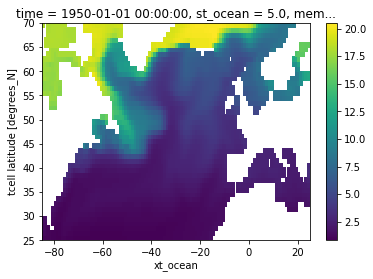

In [24]:
met_index[0,0,0,:,:].plot()

Calculate the ensembe mean metabolic index for the last ten years of the run:

In [25]:
met_index.time

<xarray.DataArray 'time' (time: 11023)>
array([cftime.DatetimeNoLeap(1950-01-01 00:00:00),
       cftime.DatetimeNoLeap(1950-01-06 00:00:00),
       cftime.DatetimeNoLeap(1950-01-11 00:00:00), ...,
       cftime.DatetimeNoLeap(2100-12-17 00:00:00),
       cftime.DatetimeNoLeap(2100-12-22 00:00:00),
       cftime.DatetimeNoLeap(2100-12-27 00:00:00)], dtype=object)
Coordinates:
  * time     (time) object 1950-01-01 00:00:00 ... 2100-12-27 00:00:00

In [26]:
MI_ENSmean_2090_2100 = met_index[:,-730:,:,:,:].mean(axis=0)
MI_ENSmean_2090_2100

<xarray.DataArray (time: 730, st_ocean: 29, yt_ocean: 45, xt_ocean: 110)>
dask.array<mean_agg-aggregate, shape=(730, 29, 45, 110), dtype=float32, chunksize=(1, 29, 45, 110)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 25.5 26.5 27.5 28.5 ... 66.5 67.5 68.5 69.5
  * time      (time) object 2091-01-01 00:00:00 ... 2100-12-27 00:00:00
  * xt_ocean  (xt_ocean) float64 -84.5 -83.5 -82.5 -81.5 ... 21.5 22.5 23.5 24.5
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 35.0 ... 270.6 298.3 335.7 384.6

Calculate time and depth average

In [27]:
MI_ENSmean_2090_2100 = MI_ENSmean_2090_2100.mean(axis=0)
MI_ENSmean_2090_2100 = MI_ENSmean_2090_2100.mean(axis=0)
MI_ENSmean_2090_2100

<xarray.DataArray (yt_ocean: 45, xt_ocean: 110)>
dask.array<mean_agg-aggregate, shape=(45, 110), dtype=float32, chunksize=(45, 110)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 25.5 26.5 27.5 28.5 ... 66.5 67.5 68.5 69.5
  * xt_ocean  (xt_ocean) float64 -84.5 -83.5 -82.5 -81.5 ... 21.5 22.5 23.5 24.5

In [28]:
MI_ENSmean_2090_2100 = MI_ENSmean_2090_2100.compute()

In [29]:
MI_ENSmean_2090_2100

<xarray.DataArray (yt_ocean: 45, xt_ocean: 110)>
array([[ 0.7983181 ,  0.8483281 ,  0.8643764 , ...,         nan,
                nan,         nan],
       [ 0.9340605 ,  0.920418  ,  0.8807415 , ...,         nan,
                nan,         nan],
       [ 0.9724695 ,  0.9333406 ,  0.74024177, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan, 15.225243  , ...,         nan,
                nan,         nan],
       [        nan,         nan, 15.363811  , ...,         nan,
                nan,         nan],
       [14.812546  ,         nan, 15.257431  , ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 25.5 26.5 27.5 28.5 ... 66.5 67.5 68.5 69.5
  * xt_ocean  (xt_ocean) float64 -84.5 -83.5 -82.5 -81.5 ... 21.5 22.5 23.5 24.5

Note the data is there now.

You plot it the xarray way:

/home/kstein/miniconda3/envs/research3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'color'
  s)


Text(0.5, 1.0, 'ESM2M ensemble average cod \nmetabolic index, 2090-2100')

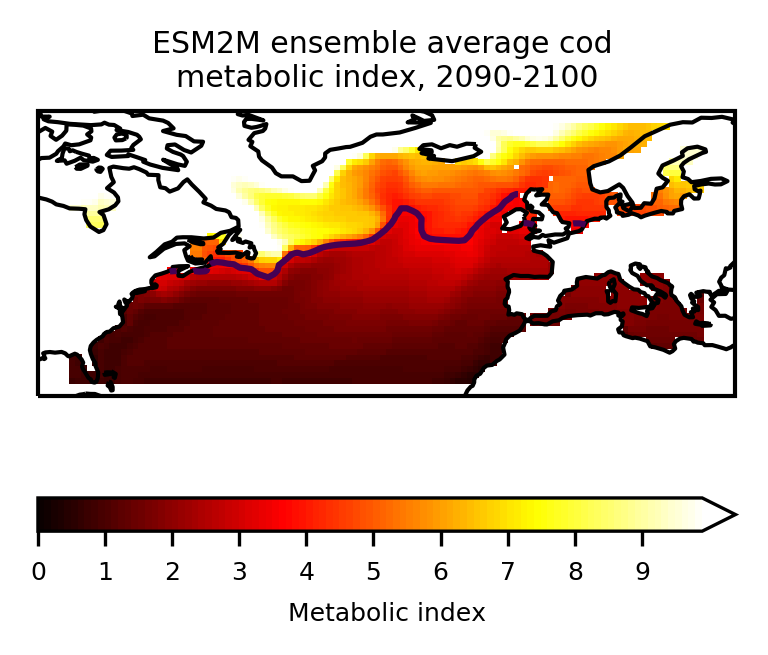

In [30]:
plt.rcParams.update({'font.size': 6})
levs = np.arange(0,10,.1)
fig = plt.figure(figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot2grid((1, 1), (0, 0),
                      projection=ccrs.PlateCarree())
ax.coastlines('110m')
cl = MI_ENSmean_2090_2100.plot(levels=levs,
                               transform=ccrs.PlateCarree(),
                               cmap=plt.cm.hot,
                               cbar_kwargs={'orientation' : 'horizontal',
                                           'label' : 'Metabolic index'})
MI_ENSmean_2090_2100.plot.contour(levels=[3.7],
                                  transform=ccrs.PlateCarree(),
                                  color='black')
plt.title('ESM2M ensemble average cod \n' +
         'metabolic index, 2090-2100')

But it's probably easier to plot more normally.

Text(0.5, 1.0, 'ESM2M ensemble average cod \nmetabolic index, 2090-2100')

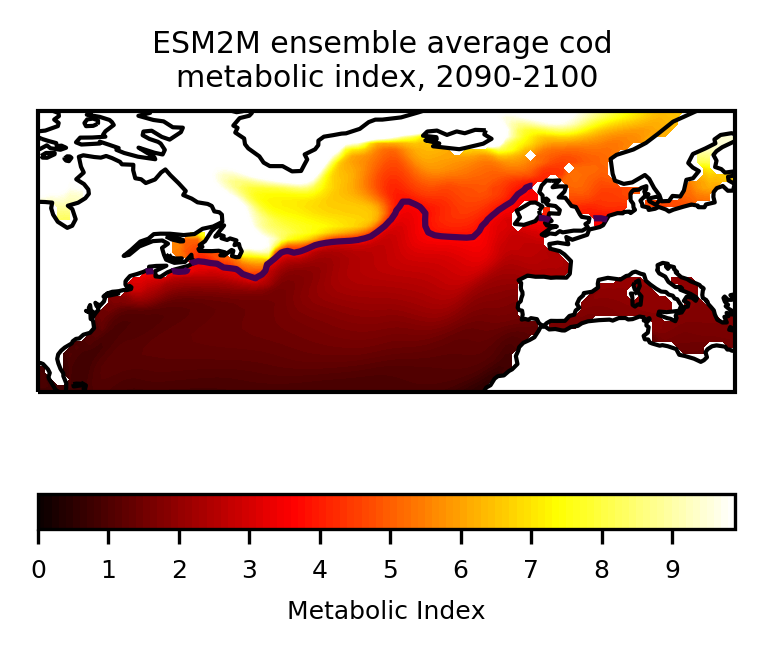

In [31]:
plt.rcParams.update({'font.size': 6})
fig = plt.figure(num=1,figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot2grid((1, 1), (0, 0),
                      projection=ccrs.PlateCarree())
ax.coastlines('110m')
cl = ax.contourf(MI_ENSmean_2090_2100.xt_ocean.data,
                 MI_ENSmean_2090_2100.yt_ocean.data,
                 MI_ENSmean_2090_2100.data,
                 levels=levs,
                 transform=ccrs.PlateCarree(),
                 cmap=plt.cm.hot)
plt.colorbar(cl,
             ax=ax,
             orientation='horizontal',
             label='Metabolic Index')
ax.contour(MI_ENSmean_2090_2100.xt_ocean.data,
           MI_ENSmean_2090_2100.yt_ocean.data,
           MI_ENSmean_2090_2100.data,
          levels=[3.7],
          color='black')
plt.title('ESM2M ensemble average cod \n' +
         'metabolic index, 2090-2100')